## Currently switching to using sparse matrix representations of the genres

Train a logistic model to classify the gender of an artist based on the list of genre labels. This approach uses sparse matrices to one-hot encode the genre labels of each artist. The features are used with and without normalization; there is no significant difference.

- [x] shuffle the data -- is it currently training in order, on all males first...
- [x] use sparse matrices - merge to main branch
- [x] use cross validation
- [x] plot confusion matrices
- [x] normalize features -  this may not help in this case
- [ ] supervised PCA?
- [ ] use dimension reduction through word embeddings 
    - [ ] LSI
    - [ ] LDA
    - [ ] HDP
- [ ] introduce length of the genre list as a new feature? or save for NN model

In [1]:
import numpy as np
import pandas as pd

from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import re

import os
from gensim import corpora

seed = 23

For gensim we need logging:

In [6]:
import logging
logging.basicConfig(format = '(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

Import the cleaned data:

In [2]:
%store -r now
now

'2020-05-18-10-06'

In [3]:
X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

In [4]:
X_train.shape, y_train.shape

((12376, 2), (12376, 1))

In [5]:
X_train.head()

,genrelist,genrelist_length
artist,,
Pablo_Holman,"['pop', 'rock', 'emo_pop']",3
Bobby_Edwards,['country'],1
La_Palabra,"['afro_cuban_jazz', 'son_montuno', 'guaracha',...",4
Sherrick,"['r_and_b', 'soul']",2
Allen_Collins,['southern_rock'],1


In [6]:
y_train.head()

,gender
artist,
Pablo_Holman,male
Bobby_Edwards,male
La_Palabra,male
Sherrick,male
Allen_Collins,male


### Genre Labels -- as a list -- NOT USED CURRENTLY

Each value of the genre column is a _string_ of comma separated genre labels using the spotify abbreviations. We want to convert it to a _list_ of strings.

In [7]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

### Genre Labels -- as a string

Each value of the genre column is a _string_ of comma separated genre labels using the spotify abbreviations. This function strips the brackets and commas and quotes, but leaves it as a string.

In [8]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets, commas, and extra quotes."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","").replace(",","")
    return string

Now we apply it to the whole column and put the lists in a new column:

In [9]:
X_train['genrelist']= X_train['genrelist'].apply(genrelist)

In [10]:
X_train.head()

,genrelist,genrelist_length
artist,,
Pablo_Holman,pop rock emo_pop,3
Bobby_Edwards,country,1
La_Palabra,afro_cuban_jazz son_montuno guaracha salsa_rom...,4
Sherrick,r_and_b soul,2
Allen_Collins,southern_rock,1


In [11]:
X_train.genrelist.iloc[0]

'pop rock emo_pop'

In [12]:
data_train = X_train.join(y_train, how = 'inner', on = 'artist')

In [13]:
data_train.head()

,genrelist,genrelist_length,gender
artist,,,
Pablo_Holman,pop rock emo_pop,3,male
Bobby_Edwards,country,1,male
La_Palabra,afro_cuban_jazz son_montuno guaracha salsa_rom...,4,male
Sherrick,r_and_b soul,2,male
Allen_Collins,southern_rock,1,male


In [14]:
data_train = data_train.sample(frac = 1, random_state = 13)

In [15]:
data_train.head()

,genrelist,genrelist_length,gender
artist,,,
Julia_Kedhammar,pop dance_pop synth_pop,3,female
Debby_Ryan,indie_pop,1,female
Gepe,pop folk electro_pop indie_folk,4,male
Nash_the_Slash,progressive_rock electronic,2,male
Dhani_Harrison,alternative_rock rock,2,male


In [16]:
data_train.reset_index(inplace = True)
data_train.index.name = 'artist_id'

In [17]:
data_train.head()

,artist,genrelist,genrelist_length,gender
artist_id,,,,
0,Julia_Kedhammar,pop dance_pop synth_pop,3,female
1,Debby_Ryan,indie_pop,1,female
2,Gepe,pop folk electro_pop indie_folk,4,male
3,Nash_the_Slash,progressive_rock electronic,2,male
4,Dhani_Harrison,alternative_rock rock,2,male


Switched to using full genre_list, not just that for the training set

In [18]:
genre_list = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now))
genre_list.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [19]:
genre_list.head()

,genre_list
0,chilean
1,zamba
2,afro_punk_blues
3,crunk
4,spanish_guitar


Import to DataFrame genres and their frequencies: 

In [20]:
genre_label_counts = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_label_counts_TRAINING_{}.csv'.format(now))
#genre_list.drop(['Unnamed: 0'], axis = 1, inplace = True)
#genre_label_counts.set_index(['Unnamed: 0'], inplace = True)
genre_label_counts.index.name = 'genre_id'
genre_label_counts.columns = ['genre','freqency']

In [21]:
genre_label_counts.head(12)

,genre,freqency
genre_id,,
0,pop,2617
1,rock,1765
2,r_and_b,1647
3,country,1613
4,hip_hop,1114
5,folk,1046
6,soul,1023
7,jazz,962
8,alternative_rock,937


Create a dictionary of {genre : genre_id}

In [22]:
genre_label_id_dict = dict(zip(genre_label_counts.genre.values.tolist(), genre_label_counts.index.tolist()))

In [23]:
genre_label_id_dict['hard_rock']

11

Now create a sparse data structure encoding of the genre labels:

In [24]:
vec = CountVectorizer(vocabulary = genre_label_id_dict) # this implementation uses scipy.sparse.csr_matrix representation

In [25]:
X_sparse = vec.fit_transform(data_train.genrelist)

In [26]:
X_sparse

<12376x1353 sparse matrix of type '<class 'numpy.int64'>'
	with 33457 stored elements in Compressed Sparse Row format>

In [27]:
X_sparse.nnz #number of stored values

33457

Let's look at the nonzero entries of a row and make sure the encoding worked properly:

In [28]:
X_sparse[677].nonzero()

(array([0, 0, 0, 0], dtype=int32), array([ 0,  5, 49, 84], dtype=int32))

Convert those id's to genre labels using the genre_label_counts DF:

In [29]:
[genre_label_counts.loc[id] for id in X_sparse[11000].nonzero()[1]]

[genre       electronic
 freqency           224
 Name: 25, dtype: object,
 genre       psychedelic
 freqency             33
 Name: 134, dtype: object]

Compare to the data_train entry:

In [30]:
data_train.loc[11000]

artist                         Nick_Nicely
genrelist           psychedelic electronic
genrelist_length                         2
gender                                male
Name: 11000, dtype: object

Checks out on some examples.

Encode labels:

In [31]:
le = preprocessing.LabelEncoder()
le.fit(['male', 'female'])
le.classes_

array(['female', 'male'], dtype='<U6')

In [32]:
le.transform(['female'])

array([0])

In [33]:
le.inverse_transform([1,0,1])

array(['male', 'female', 'male'], dtype='<U6')

In [34]:
y = le.transform(data_train.gender.values)

### Normalization
Convert inputs to a numpy array and then create a scaler class to normalize the feature values that can be applied to training and test data.

In [35]:
# X = X_train.vector.values.tolist()
# X = np.stack(X, axis = 0)
#scaler = preprocessing.StandardScaler(with_mean = False).fit(X_sparse) # need with_mean = False for sparse data
transformer = preprocessing.MaxAbsScaler(copy = False).fit(X_sparse)

In [36]:
transformer.scale_, transformer.max_abs_

(array([2., 1., 1., ..., 1., 1., 1.]), array([2., 1., 1., ..., 1., 1., 1.]))

Apply the scaler to the training data:

In [37]:
X_scaled = transformer.transform(X_sparse)

In [38]:
X_scaled.shape

(12376, 1353)

### Create the Model

Define the class of models.

Needed to increase max_iter for it to converge. A high value of C (>1) helps the score a little bit. Recall, C controls the amount of regularization: low C imples strong regularization, high C implies weak regularization. Using l1_ratio between 0 and 1 gives a combination of l1 and l2; l1_ration = 1 is pure l1.

In [55]:
model = LogisticRegression(penalty = 'l1', solver = 'saga', random_state = 0, max_iter = 10000, C = 5 )

Train the model on the training data:

In [56]:
#model.fit(X_sparse,y)
model.fit(X_scaled,y)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Can look at predictions:

In [52]:
#model.predict(X_sparse[:3,:])
model.predict(X_scaled[:3,:])

array([0, 0, 0])

In [53]:
print('The percentage of male artists in the training set is {}%.'.format(round(100*y.sum()/y.shape[0])))

The percentage of male artists in the training set is 69.0%.


Score the model:

In [54]:
#model.score(X_sparse,y)
model.score(X_scaled,y)

0.7709276018099548

We see that it is a little better than the baseline of .69 obtained by always predicting that the artist is male.

### Cross validation.

This function can be run on the normalized and un-normalized data:

In [57]:
def train_validate(x_data, y_data):
    """This function takes X,y data and returns 
    (list of cvscores, list of confusion matrices). It
    prints basic stats.
    """

    kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

    cvscores = []
    cms = []
    for train, val in kf.split(x_data,y_data):

    #CODE BELOW NEEDS TO BE ADAPTED TO THIS NB
        X_train = x_data[train]
        y_train = y_data[train]

        model.fit(X_train, y_train);

        X_val = x_data[val]
        y_val = y_data[val]

        score = model.score(X_val, y_val)
        cvscores.append(score)

        # compute confusion matrices and store them in a list
        y_pred = model.predict(X_val)
        cms.append(confusion_matrix(y_val, y_pred))

    print(f'Mean accuracy is {100*np.mean(cvscores):.2f}% and 100*STD is {100*np.std(cvscores):.2f}%')
    print(f'This is a {100*(100*np.mean(cvscores)-69)/69:.2f}% improvement over a random guess.')
    
    return cvscores, cms

Without normalization:

In [58]:
cvscores, cms = train_validate(X_sparse, y)

Mean accuracy is 73.76% and 100*STD is 1.26%
This is a 6.90% improvement over a random guess.


Let's look at the confusion matrices:

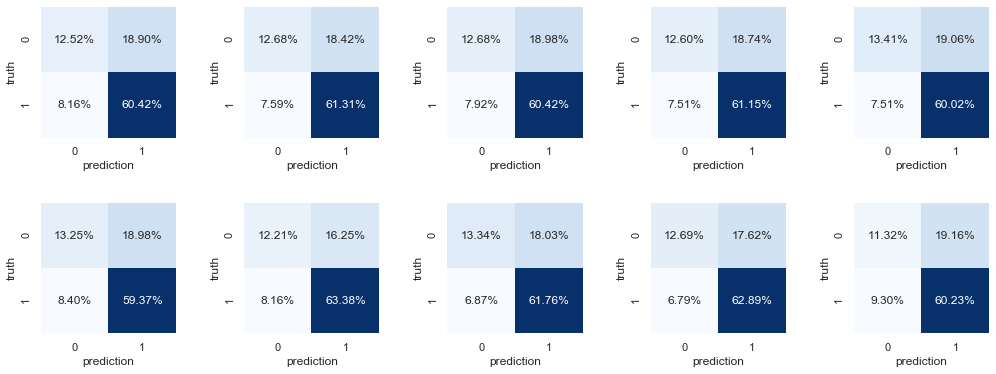

In [59]:
plt.figure(figsize=(17,6))
for i, cm in enumerate(cms):
    plt.subplot(2,5,i+1)
    sns.heatmap(cm/np.sum(cm), annot = True, fmt = '.2%', cmap = 'Blues', cbar = False)
    plt.ylabel('truth')
    plt.xlabel('prediction')
    plt.subplots_adjust(wspace = .5, hspace = .5)

### With normalization:

In [ ]:
cvscores, cms = train_validate(X_scaled, y)

The normalization does not make a significant difference.

Let's look at the confusion matrices:

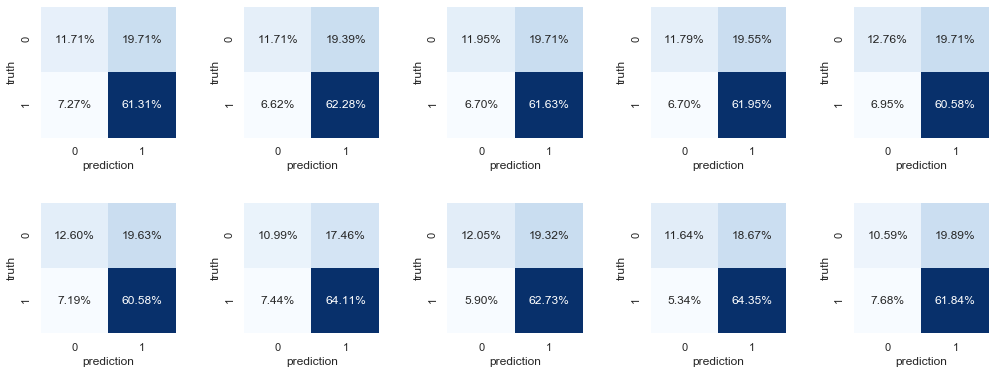

In [80]:
plt.figure(figsize=(17,6))
for i, cm in enumerate(cms):
    plt.subplot(2,5,i+1)
    sns.heatmap(cm/np.sum(cm), annot = True, fmt = '.2%', cmap = 'Blues', cbar = False)
    plt.ylabel('truth')
    plt.xlabel('prediction')
    plt.subplots_adjust(wspace = .5, hspace = .5)

### Word Embeddings

We now preprocess the features using word embeddings:
- [ ] LSI. First use TF-IDF then LSI.
- [ ] LDA
- [ ] HDP

To use these we proceed as follows using the gensim library:

1. Create a dictionary using the list of genres and store this as .dict file. Preferably ordered by frequency?
2. Tokenize the corpus and store as a .mm file
3. Create (e.g. LSI) model. The dimension of the embedding vector space, $d$, is a hyper-parameter to be chosen using cross validation.
4. From the image of the corpus in the embedding space, define a new feature array, X_embed
5. Apply the classifier with cross validation for a range of $d$ and a range of hyper-parameters of the classifier.
    - [ ] use scikit learn grid search class
6. Select a hyper-parameters.

LSI
=========